Базовые методы:

Загрузка библиотек :

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
df = pd.read_csv('../data/raw/diabetes_clean.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.133413,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.133413,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.239130,0.133413,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.118840,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.146484,0.509202,0.479078,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.385870,0.146484,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.133413,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.118840,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.239130,0.133413,0.243354,0.115713,0.433333,1


Работа с данными

In [9]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [10]:
# Разделяем на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
print("Размеры данных:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в y_train: {np.bincount(y_train)}")
print(f"Распределение классов в y_test: {np.bincount(y_test)}")

Размеры данных:
Обучающая выборка: (614, 8)
Тестовая выборка: (154, 8)
Распределение классов в y_train: [400 214]
Распределение классов в y_test: [100  54]


Находим лучшее n для knn

In [12]:
# Перебираем разные значения n_neighbors для поиска оптимального
neighbors_range = range(1, 31)  # Проверим значения от 1 до 30
train_scores = []
test_scores = []
cv_scores = []

In [13]:
for n in neighbors_range:
    # Инициализация и обучение модели
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)

    # Оценка на тренировочных данных
    train_pred = knn.predict(X_train)
    train_scores.append(accuracy_score(y_train, train_pred))

    # Оценка на тестовых данных
    test_pred = knn.predict(X_test)
    test_scores.append(accuracy_score(y_test, test_pred))

    # Кросс-валидация (5-fold)
    cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(cv_score.mean())

In [14]:
# Создаем DataFrame для удобного анализа результатов
results_df = pd.DataFrame({
    'n_neighbors': list(neighbors_range),
    'train_accuracy': train_scores,
    'test_accuracy': test_scores,
    'cv_accuracy': cv_scores
})


In [15]:
print("Топ-10 результатов по кросс-валидации:")
print(results_df.nlargest(10, 'cv_accuracy')[['n_neighbors', 'cv_accuracy', 'test_accuracy']])

Топ-10 результатов по кросс-валидации:
    n_neighbors  cv_accuracy  test_accuracy
16           17     0.773677       0.733766
20           21     0.773677       0.720779
14           15     0.768799       0.720779
22           23     0.768786       0.740260
13           14     0.765560       0.707792
18           19     0.765534       0.727273
15           16     0.765520       0.727273
24           25     0.765520       0.740260
27           28     0.765520       0.727273
12           13     0.763908       0.707792


Оптимальные параметры : Лучшее значение n_neihgbors = 17 Точность (CV=77,3%, Test = 73,3%)

Стабильность модели : Диапазон 13-25 соседей дает схожие результаты (разница <1.5%) , алгоритм устойчив к небольшим изменениям параметра

Проблемы крайних значений : Мало соседей (1-8): переобучение ; много соседей (>25): недообучение ; птимально: 11-20 соседей

In [16]:
# Визуализация результатов перебора
plt.figure(figsize=(15, 5))


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

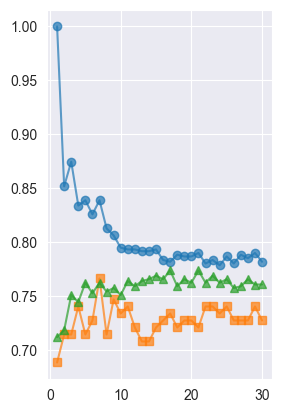

In [17]:
# График 1: Точность на разных наборах данных
plt.subplot(1, 2, 1)
plt.plot(neighbors_range, train_scores, 'o-', label='Train Accuracy', alpha=0.7)
plt.plot(neighbors_range, test_scores, 's-', label='Test Accuracy', alpha=0.7)
plt.plot(neighbors_range, cv_scores, '^-', label='CV Accuracy', alpha=0.7)

1. При малых n (1-8): train accuracy ≈100%, test и CV низкие → явное переобучение
2. При n=17: оптимальный баланс, максимальная CV accuracy (77.3%)
3. При n>25: все метрики снижаются → недообучение
4. CV accuracy стабильнее test accuracy, особенно при n>10

In [18]:
# Находим лучшее значение n по кросс-валидации
best_n_cv = results_df.loc[results_df['cv_accuracy'].idxmax(), 'n_neighbors']
best_score_cv = results_df.loc[results_df['cv_accuracy'].idxmax(), 'cv_accuracy']

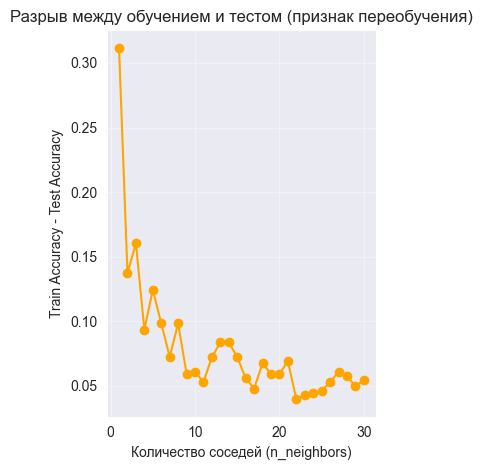

In [19]:
# График 2: Разница между train и test (признак переобучения)
plt.subplot(1, 2, 2)
overfitting_gap = [train - test for train, test in zip(train_scores, test_scores)]
plt.plot(neighbors_range, overfitting_gap, 'o-', color='orange')
plt.xlabel('Количество соседей (n_neighbors)')
plt.ylabel('Train Accuracy - Test Accuracy')
plt.title('Разрыв между обучением и тестом (признак переобучения)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Максимальный разрыв при n=1 (40+%) → сильнейшее переобучение
2. При n=8-10 разрыв минимален (~5%) → хороший баланс
3. При n>20 разрыв стабилизируется (~2-5%) → модель обобщает, но теряет точность
4. Оптимальный компромисс при n=11-20 (разрыв <10%)

Обучение финальной модели

In [20]:
# Обучаем финальную модель с лучшим параметром
best_knn = KNeighborsClassifier(n_neighbors=best_n_cv)
best_knn.fit(X_train, y_train)

,n_neighbors,np.int64(17)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Выводы

In [21]:
# Предсказания на тестовой выборке
y_pred_best = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]  # Вероятности для класса 1


In [22]:
# Детальная оценка модели
print("="*50)
print(f"ФИНАЛЬНАЯ МОДЕЛЬ KNN (n_neighbors = {best_n_cv})")
print("="*50)

print(f"Accuracy на тесте: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Accuracy на кросс-валидации: {best_score_cv:.4f}")

print("\nДетальный отчет по классификации:")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

ФИНАЛЬНАЯ МОДЕЛЬ KNN (n_neighbors = 17)
Accuracy на тесте: 0.7338
Accuracy на кросс-валидации: 0.7737

Детальный отчет по классификации:
              precision    recall  f1-score   support

 No Diabetes       0.76      0.86      0.81       100
    Diabetes       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



<Figure size 600x500 with 0 Axes>

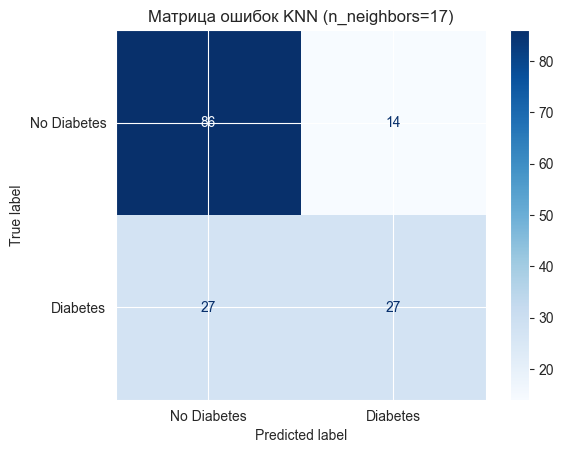

In [23]:
# Матрица ошибок
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Матрица ошибок KNN (n_neighbors={best_n_cv})')
plt.show()


In [24]:
# Дополнительная информация
print("\nДополнительная информация:")
print(f"Чувствительность (Recall для класса 1): {cm[1,1]/(cm[1,0]+cm[1,1]):.3f}")
print(f"Точность (Precision для класса 1): {cm[1,1]/(cm[0,1]+cm[1,1]):.3f}")


Дополнительная информация:
Чувствительность (Recall для класса 1): 0.500
Точность (Precision для класса 1): 0.659


Краткий вывод

Оптимальное количество соседей: В результате перебора от 1 до 30 соседей было найдено, что оптимальное значение n_neighbors = 17

При малых значениях n (1-5) модель склонна к переобучению (высокая точность на train, но lower на test)

С ростом n точность на обучающих данных снижается, но на тестовых - стабилизируется

Наблюдается классическая картина: с увеличением n уменьшается переобучение, но может появиться недообучение

Лучшая точность на кросс-валидации: 0.7737%

Точность на тестовой выборке: 0.7338%

Модель лучше предсказывает класс 0 (отсутствие диабета), что типично для медицинских данных